# Hindmarsh-Roseモデル

\begin{equation}
\left\{
    \begin{aligned}
        \dot{V} &= n - a V^3 + b V^2 - h + I,\\
        \dot{n} &= c - d V^2 -n.
    \end{aligned}
\right.    
\end{equation}

In [1]:
import numpy as np
import pathfollowing as pf
from scipy.integrate import ode, solve_ivp
from scipy.linalg import solve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set('poster', 'whitegrid', 'dark', rc={"lines.linewidth": 2, 'grid.linestyle': '-'})

In [2]:
def f(x, a):
    return np.array([x[1] - x[0]**3 + 3 * x[0]**2 - a[0] + 2, 1 - 5*x[0]**2 - x[1]])

def fx(x, a):
    return np.array([[-3*x[0]**2+6*x[0], 1.0],[-10*x[0], -1.0]])

def fa(x, a):
    return np.array([-1.0, 0.0])

In [3]:
def HR(t, x, a,b,c,d,I,h):
    return np.array([x[1] - a*x[0]**3 + b * x[0]**2 - h + I, c - d*x[0]**2 - x[1]])

## 平衡点の追跡

ルンゲ・クッタ法で安定平衡点を見つける

In [4]:
h = 1.0
x0 = np.array([1.0, -4.52182801])
r = ode(HR).set_integrator('dop853')
r.set_initial_value(x0, 0.0).set_f_params(1.0, 3.0, 1.0, 5.0, 2.0, 5.0)
sol = []
while r.successful and r.t < 100:
    sol.append(r.integrate(r.t+h))
print(sol[-1])

[ -2.3593041  -26.83157883]


平衡点の追跡

In [5]:
x=np.array([-2.35930409, -26.83157885])
a=np.array([5.0])
bdeq,bpeq,lpeq=pf.pathfollow(x, a, f, fx, fa,nmax=175, h=0.1, epsr=1.0e-10, epsb=1.0e-10, quiet=True)
bdeq2,bpeq2,lpeq2=pf.pathfollow(x, a, f, fx, fa,nmax=500, h=-0.1, epsr=1.0e-10, epsb=1.0e-10, quiet=True)

In [6]:
bdeq_r = np.array([bdeq[m]['a'][0] for m in range(len(bdeq))])
bdeq_V = np.array([bdeq[m]['x'][0] for m in range(len(bdeq))])
bdeq2_r = np.array([bdeq2[m]['a'][0] for m in range(len(bdeq2))])
bdeq2_V = np.array([bdeq2[m]['x'][0] for m in range(len(bdeq2))])

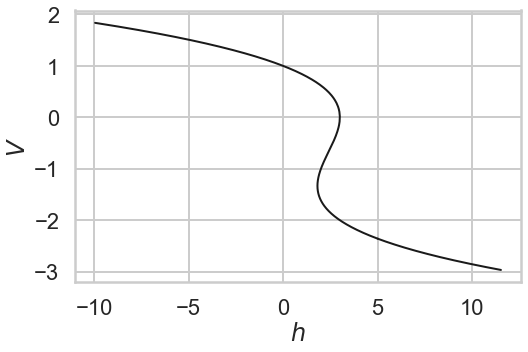

In [7]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.set_xlabel("$h$")
ax.set_ylabel("$V$")
ax.plot(bdeq_r, bdeq_V, '-k')
ax.plot(bdeq2_r, bdeq2_V, '-k')
# plt.savefig("bd_lrz.pdf", bbox_inches='tight')

ルンゲ・クッタ法でリミットサイクルをみつける

In [8]:
Npts=100
t1 = 2.08742151
h = t1/Npts
x0 = np.array([1.0, -4.52182801])
r = ode(HR).set_integrator('dop853')
r.set_initial_value(x0, 0.0).set_f_params(1.0, 3.0, 1.0, 5.0, 2.0, -6.0)
sol = []
while r.successful and r.t < t1:
    sol.append(r.integrate(r.t+h))

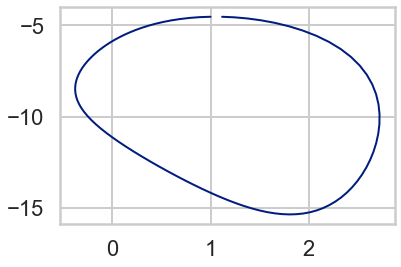

In [9]:
sol2 = np.array(sol)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol2[:,0], sol2[:,1], '-')
# ax.plot(sol2[:,1], '-')

## 単純射撃法

In [11]:
def func(x, a):
    T = x[-1]
    def f2(t, y):
        return T * f(y, a)
    r = ode(f2).set_integrator('dop853', atol=1e-10, rtol=1e-10)
    y0 = np.copy(x[:-1])
    h = 1.0
    r.set_initial_value(y0, 0.0)
    y1 = r.integrate(r.t+h)
    x1 = np.zeros(len(x))
    x1[:-1] = y1 - y0
    x1[-1] = y0[0] - 1.0
    return x1

def dfdx(x, a):
    def df2(t, y, n):
        z = np.zeros((n+1)*(n+2))
        z[:n] = y[n] * f(y[:n], a)
        z[n] = 0.0
        J = np.zeros((n+1, n+1))
        J[:n, :n] = y[n] * fx(y[:n], a)
        J[:n, n] = f(y[:n], a)
        for m in range(n+1):
            z[(n+1)*(m+1):(n+1)*(m+2)] = J @ y[(n+1)*(m+1):(n+1)*(m+2)]
        return z
    r = ode(df2).set_integrator('dop853', atol=1e-10, rtol=1e-10)
    n = len(x)-1
    y0 = np.zeros((n+1)*(n+2))
    I = np.identity(n+1)
    y0[:n+1] = np.copy(x)
    for m in range(n+1):
        y0[(n+1)*(m+1):(n+1)*(m+2)] = I[:,m]
    h = 1.0
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    A = -np.identity(n+1)
    for m in range(n+1):
        A[:-1,m] += y1[(n+1)*(m+1):(n+1)*(m+2)-1]
    A[-1,:] = 0.0
    A[-1,0] = 1.0 
    return A

def dfda(x, a):
    T = x[-1]
    def df2(t, y, n):
        z = np.zeros(2*(n+1))
        z[:n] = T * f(y[:n], np.array([y[n]]))
        z[n] = 0.0
        J = np.zeros((n+1, n+1))
        J[:n, :n] = fx(y[:n], np.array([y[n]]))
        J[:n, n] = fa(y[:n], np.array([y[n]]))
        z[n+1:] = T * J @ y[n+1:]
        return z
    r = ode(df2).set_integrator('dop853', atol=1e-10, rtol=1e-10)
    n = len(x)-1
    y0 = np.zeros(2*(n+1))
    y0[:n] = np.copy(x[:-1])
    y0[n] = a[0]
    y0[-1] = 1.0
    h = 1.0
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    y1[-1] = 0.0
    return y1[n+1:]

ニュートン法でリミットサイクルをとらえる

In [12]:
x = np.array([1.0, -4.52182801, 2.08742151])
a = np.array([-6.0])
y = np.copy(x)
for m in range(10):
    b = func(y, a)
    A = dfdx(y, a)
    y -= solve(A, b)
    print(y, np.linalg.norm(b))

[ 1.         -4.52182801  2.08742151] 6.414228767527237e-09
[ 1.         -4.52182801  2.08742151] 1.5419315200832576e-14
[ 1.         -4.52182801  2.08742151] 2.094764613337708e-15
[ 1.         -4.52182801  2.08742151] 1.0473823066688541e-14
[ 1.         -4.52182801  2.08742151] 4.0943002132167226e-15
[ 1.         -4.52182801  2.08742151] 2.3914935841127266e-15
[ 1.         -4.52182801  2.08742151] 1.434939100499837e-14
[ 1.         -4.52182801  2.08742151] 6.2803698347351005e-15
[ 1.         -4.52182801  2.08742151] 8.848414820926143e-15
[ 1.         -4.52182801  2.08742151] 6.0402662910232525e-15


リミットサイクルを追跡

In [13]:
x=np.array([1.0, -4.52182801, 2.08742151])
a=np.array([-6.0])
bd,bp,lp=pf.pathfollow(x, a, func, dfdx, dfda,nmax=175, h=0.1, epsr=1.0e-10, epsb=1.0e-10, quiet=True)

In [14]:
bd2,bp2,lp2=pf.pathfollow(x, a, func, dfdx, dfda,nmax=50, h=-0.1, epsr=1.0e-10, epsb=1.0e-10, quiet=True)

In [15]:
bd_r = np.array([bd[m]['a'][0] for m in range(len(bd))])
bd_T = np.array([bd[m]['x'][-1] for m in range(len(bd))])
bd2_r = np.array([bd2[m]['a'][0] for m in range(len(bd2))])
bd2_T = np.array([bd2[m]['x'][-1] for m in range(len(bd2))])

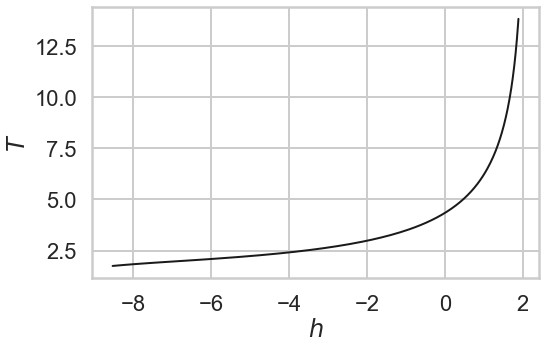

In [16]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.set_xlabel("$h$")
ax.set_ylabel("$T$")
ax.plot(bd_r, bd_T, '-k')
ax.plot(bd2_r, bd2_T, '-k')

## 単純射撃法
別の位相条件$\dot{n}=0$のもとで解く

In [17]:
def func(x, a):
    T = x[-1]
    def f2(t, y):
        return T * f(y, a)
    r = ode(f2).set_integrator('dop853', atol=1e-10, rtol=1e-10)
    y0 = np.copy(x[:-1])
    h = 1.0
    r.set_initial_value(y0, 0.0)
    y1 = r.integrate(r.t+h)
    x1 = np.zeros(len(x))
    x1[:-1] = y1 - y0
    x1[-1] = 1.0 - 5 * x[0]**2 - x[1]
    return x1

def dfdx(x, a):
    def df2(t, y, n):
        z = np.zeros((n+1)*(n+2))
        z[:n] = y[n] * f(y[:n], a)
        z[n] = 0.0
        J = np.zeros((n+1, n+1))
        J[:n, :n] = y[n] * fx(y[:n], a)
        J[:n, n] = f(y[:n], a)
        for m in range(n+1):
            z[(n+1)*(m+1):(n+1)*(m+2)] = J @ y[(n+1)*(m+1):(n+1)*(m+2)]
        return z
    r = ode(df2).set_integrator('dop853', atol=1e-10, rtol=1e-10)
    n = len(x)-1
    y0 = np.zeros((n+1)*(n+2))
    I = np.identity(n+1)
    y0[:n+1] = np.copy(x)
    for m in range(n+1):
        y0[(n+1)*(m+1):(n+1)*(m+2)] = I[:,m]
    h = 1.0
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    A = -np.identity(n+1)
    for m in range(n+1):
        A[:-1,m] += y1[(n+1)*(m+1):(n+1)*(m+2)-1]
    A[-1,:] = 0.0
    A[-1,0] = -10*x[0]
    A[-1,1] = -1.0 
    return A

def dfda(x, a):
    T = x[-1]
    def df2(t, y, n):
        z = np.zeros(2*(n+1))
        z[:n] = T * f(y[:n], np.array([y[n]]))
        z[n] = 0.0
        J = np.zeros((n+1, n+1))
        J[:n, :n] = fx(y[:n], np.array([y[n]]))
        J[:n, n] = fa(y[:n], np.array([y[n]]))
        z[n+1:] = T * J @ y[n+1:]
        return z
    r = ode(df2).set_integrator('dop853', atol=1e-10, rtol=1e-10)
    n = len(x)-1
    y0 = np.zeros(2*(n+1))
    y0[:n] = np.copy(x[:-1])
    y0[n] = a[0]
    y0[-1] = 1.0
    h = 1.0
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    y1[-1] = 0.0
    return y1[n+1:]

ニュートン法でリミットサイクルをとらえる

In [18]:
x = np.array([1.05065903, -4.51942199, 2.08742151])
a = np.array([-6.0])
y = np.copy(x)
for m in range(10):
    b = func(y, a)
    A = dfdx(y, a)
    y -= solve(A, b)
    print(y, np.linalg.norm(b))
x = np.copy(y)
print(x)

[ 1.05065902 -4.51942191  2.08742151] 8.126602303125586e-08
[ 1.05065902 -4.51942191  2.08742151] 3.794299872214038e-15
[ 1.05065902 -4.51942191  2.08742151] 3.447059237218225e-15
[ 1.05065902 -4.51942191  2.08742151] 6.951095629092365e-15
[ 1.05065902 -4.51942191  2.08742151] 9.103828801926284e-15
[ 1.05065902 -4.51942191  2.08742151] 1.0367366991496098e-14
[ 1.05065902 -4.51942191  2.08742151] 8.68248353037211e-15
[ 1.05065902 -4.51942191  2.08742151] 3.5596458096434965e-15
[ 1.05065902 -4.51942191  2.08742151] 1.897149936107019e-15
[ 1.05065902 -4.51942191  2.08742151] 8.405495513285155e-15
[ 1.05065902 -4.51942191  2.08742151]


リミットサイクルを追跡する

In [19]:
a=np.array([-6.0])
bd,bp,lp=pf.pathfollow(x, a, func, dfdx, dfda,nmax=100, h=0.25, epsr=1.0e-10, epsb=1.0e-10, amax=2.08, quiet=True)

In [20]:
bd2,bp2,lp2=pf.pathfollow(x, a, func, dfdx, dfda,nmax=100, h=-0.25, epsr=1.0e-10, epsb=1.0e-10, amax=2.08,amin=-9.59, quiet=True)

# parameter arrived at boundary


In [21]:
bd_r = np.array([bd[m]['a'][0] for m in range(len(bd))])
bd_T = np.array([bd[m]['x'][-1] for m in range(len(bd))])
bd_V = np.array([np.max(bd[m]['x'][0]) for m in range(len(bd))])
bd_Vmax = np.array([np.max(bd[m]['x'][0]) for m in range(len(bd))])
bd_Vmin = np.array([np.min(bd[m]['x'][0]) for m in range(len(bd))])
bd2_r = np.array([bd2[m]['a'][0] for m in range(len(bd2))])
bd2_T = np.array([bd2[m]['x'][-1] for m in range(len(bd2))])
bd2_V = np.array([np.max(bd2[m]['x'][0]) for m in range(len(bd2))])
bd2_Vmax = np.array([np.max(bd2[m]['x'][0]) for m in range(len(bd2))])
bd2_Vmin = np.array([np.min(bd2[m]['x'][0]) for m in range(len(bd2))])

各パラメータにおけるリミットサイクルの$V$成分の最大値・最小値を調べる

In [22]:
N = 100
Vmax, Vmin = [], []
for pt in bd:
    x0, a0, T = pt['x'][:-1], pt['a'][0], pt['x'][-1]
    dt = T / N
    r = ode(HR).set_integrator('dop853')
    r.set_initial_value(x0, 0.0).set_f_params(1.0, 3.0, 1.0, 5.0, 2.0, a0)
    V0, V1 = x0[0], x0[0]
    while r.successful and r.t < T:
        y0 = r.integrate(r.t+dt)
        V0 = y0[0] if y0[0] > V0 else V0
        V1 = y0[0] if y0[0] < V1 else V1
    Vmax.append(V0)
    Vmin.append(V1)
bd_Vmax = np.array(Vmax)
bd_Vmin = np.array(Vmin)

In [23]:
N = 100
Vmax, Vmin = [], []
for pt in bd2:
    x0, a0, T = pt['x'][:-1], pt['a'][0], pt['x'][-1]
    dt = T / N
    r = ode(HR).set_integrator('dop853')
    r.set_initial_value(x0, 0.0).set_f_params(1.0, 3.0, 1.0, 5.0, 2.0, a0)
    V0, V1 = x0[0], x0[0]
    while r.successful and r.t < T:
        y0 = r.integrate(r.t+dt)
        V0 = y0[0] if y0[0] > V0 else V0
        V1 = y0[0] if y0[0] < V1 else V1
    Vmax.append(V0)
    Vmin.append(V1)
bd2_Vmax = np.array(Vmax)
bd2_Vmin = np.array(Vmin)

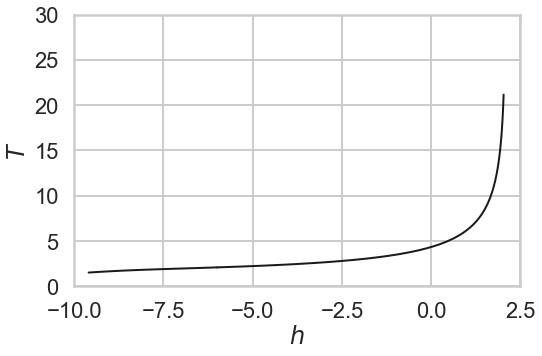

In [24]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.set_xlim(-10,2.5)
ax.set_ylim(0,30)
ax.set_xlabel("$h$")
ax.set_ylabel("$T$")
ax.plot(bd_r, bd_T, '-k')
ax.plot(bd2_r, bd2_T, '-k')

平衡点とリミットサイクルの分岐図を描画

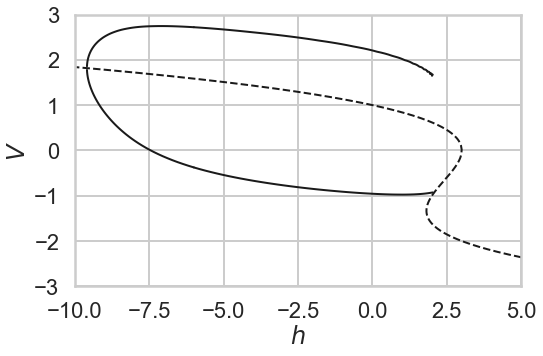

In [25]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.set_xlim(-10,5)
ax.set_ylim(-3,3)
ax.set_xlabel("$h$")
ax.set_ylabel("$V$")
ax.plot(bdeq_r, bdeq_V, '--k')
ax.plot(bdeq2_r, bdeq2_V, '--k')
ax.plot(bd_r, bd_Vmax, '-k')
ax.plot(bd_r, bd_Vmin, '-k')
ax.plot(bd2_r, bd2_Vmax, '-k')
ax.plot(bd2_r, bd2_Vmin, '-k')
# plt.savefig("bd_HR_V.pdf", bbox_inches='tight')

## 多段射撃法

In [26]:
def HR(t, x, a,b,c,d,I,h):
    return np.array([x[1] - a*x[0]**3 + b * x[0]**2 - h + I, c - d*x[0]**2 - x[1]])

In [27]:
Npts=100
t1 = 2.08742151
h = t1/Npts
x0 = np.array([1.0, -4.52182801])
r = ode(HR).set_integrator('dop853')
r.set_initial_value(x0, 0.0).set_f_params(1.0, 3.0, 1.0, 5.0, 2.0, -6.0)
sol = []
while r.successful and r.t < t1:
    sol.append(r.integrate(r.t+h))

In [28]:
def func(x, a):
    T = x[-1]
    def f2(t, y):
        return T * f(y, a)
    r = ode(f2).set_integrator('dop853', atol=1.0e-14, rtol=1.0e-14)
    n = (len(x) - 1) // Npts
    h = 1.0 / Npts
    x1 = np.zeros(len(x))

    for k in range(Npts-1):
        y0 = np.copy(x[k*n:(k+1)*n])
        r.set_initial_value(y0, 0.0)
        y1 = r.integrate(r.t+h)
        x1[k*n:(k+1)*n] = y1 - x[(k+1)*n:(k+2)*n]

    y0 = np.copy(x[-(n+1):-1])
    r.set_initial_value(y0, 0.0)
    y1 = r.integrate(r.t+h)
    x1[-(n+1):-1] = y1 - x[:n]

    x1[-1] = x[0]
    return x1

def dfdx(x, a):
    def df2(t, y, n):
        z = np.zeros((n+1)*(n+2))
        z[:n] = y[n] * f(y[:n], a)
        z[n] = 0.0
        J = np.zeros((n+1, n+1))
        J[:n, :n] = y[n] * fx(y[:n], a)
        J[:n, n] = f(y[:n], a)
        for m in range(n+1):
            z[(n+1)*(m+1):(n+1)*(m+2)] = J @ y[(n+1)*(m+1):(n+1)*(m+2)]
        return z
    r = ode(df2).set_integrator('dop853', atol=1.0e-14, rtol=1.0e-14)
    n = (len(x)-1) // Npts
    h = 1.0 / Npts
    A = np.zeros((len(x), len(x)))
    I = np.identity(n+1)

    for k in range(Npts-1):
        y0 = np.zeros((n+1)*(n+2))
        y0[:n] = x[k*n:(k+1)*n]
        y0[n] = x[-1]
        for m in range(n+1):
            y0[(n+1)*(m+1):(n+1)*(m+2)] = I[:,m]
        r.set_initial_value(y0, 0.0).set_f_params(n)
        y1 = r.integrate(r.t+h)
        for m in range(n):
            A[k*n:(k+1)*n,k*n+m] = y1[(n+1)*(m+1):(n+1)*(m+1)+n]
        A[k*n:(k+1)*n, (k+1)*n:(k+2)*n] = -np.identity(n)
        A[k*n:(k+1)*n, -1] = y1[-(n+1):-1]

    y0 = np.zeros((n+1)*(n+2))
    y0[:n] = x[-(n+1):-1]
    y0[n] = x[-1]
    for m in range(n+1):
        y0[(n+1)*(m+1):(n+1)*(m+2)] = I[:,m]
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    for m in range(n):
        A[-(n+1):-1,-(n+1)+m] = y1[(n+1)*(m+1):(n+1)*(m+1)+n]
    A[-(n+1):-1, :n] = -np.identity(n)
    A[-(n+1):-1, -1] = y1[-(n+1):-1]
    A[-1,0] = 1.0
    return A

def dfda(x, a):
    T = x[-1]
    def df2(t, y, n):
        z = np.zeros(2*(n+1))
        z[:n] = T * f(y[:n], np.array([y[n]]))
        z[n] = 0.0
        J = np.zeros((n+1, n+1))
        J[:n, :n] = fx(y[:n], np.array([y[n]]))
        J[:n, n] = fa(y[:n], np.array([y[n]]))
        z[n+1:] = T * J @ y[n+1:]
        return z
    n = (len(x) - 1) // Npts
    h = 1.0 / Npts
    r = ode(df2).set_integrator('dop853', atol=1e-14, rtol=1e-14)
    b = np.zeros(len(x))

    for k in range(Npts-1):
        y0 = np.zeros(2*(n+1))
        y0[:n] = np.copy(x[k*n:(k+1)*n])
        y0[n] = a[0]
        y0[-1] = 1.0
        r.set_initial_value(y0, 0.0).set_f_params(n)
        y1 = r.integrate(r.t+h)
        b[k*n:(k+1)*n] = y1[n+1:2*n+1]

    y0[:n] = np.copy(x[-(n+1):-1])
    y0[n] = a[0]
    y0[-1] = 1.0
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    b[-(n+1):-1] = y1[n+1:2*n+1]

    return b

In [29]:
x = []
for y in sol:
    for z in y:
        x.append(z)
x.append(t1)
x = np.array(x)

リミットサイクルの追跡

In [31]:
a=np.array([-6.0])
bd,bp,lp=pf.pathfollow(x, a, func, dfdx, dfda,nmax=220, h=0.5, epsr=1.0e-10, epsb=1.0e-10, quiet=True)

In [32]:
bd2,bp2,lp2=pf.pathfollow(bd[-1]['x'], bd[-1]['a'], func, dfdx, dfda,nmax=20, h=0.5, epsr=1.0e-10, epsb=1.0e-10, quiet=True)

In [33]:
bd = bd+bd2

In [34]:
bd3,bp3,lp3=pf.pathfollow(bd[0]['x'], bd[0]['a'], func, dfdx, dfda,nmax=100, h=-1.0, epsr=1.0e-10, epsb=1.0e-10, quiet=True)

In [35]:
bd_r = np.array([bd[m]['a'][0] for m in range(len(bd))])
bd_T = np.array([bd[m]['x'][-1] for m in range(len(bd))])
bd_Vmax = np.array([np.max(bd[m]['x'][:-1:2]) for m in range(len(bd))])
bd_Vmin = np.array([np.min(bd[m]['x'][:-1:2]) for m in range(len(bd))])
bd3_r = np.array([bd3[m]['a'][0] for m in range(len(bd3))])
bd3_T = np.array([bd3[m]['x'][-1] for m in range(len(bd3))])
bd3_Vmax = np.array([np.max(bd3[m]['x'][:-1:2]) for m in range(len(bd3))])
bd3_Vmin = np.array([np.min(bd3[m]['x'][:-1:2]) for m in range(len(bd3))])

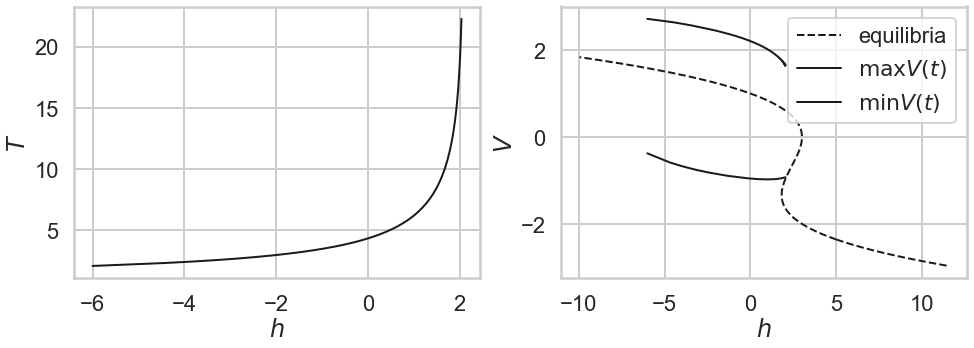

In [36]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax.set_xlabel("$h$")
ax.set_ylabel("$T$")
ax.plot(bd_r, bd_T, '-k')
ax2.set_xlabel("$h$")
ax2.set_ylabel("$V$")
ax2.plot(bdeq_r, bdeq_V, '--k', label="equilibria")
ax2.plot(bdeq2_r, bdeq2_V, '--k')
ax2.plot(bd_r, bd_Vmax, '-k', label='$\max V(t)$')
ax2.plot(bd_r, bd_Vmin, '-k', label='$\min V(t)$')
ax2.legend()
# plt.savefig("bd_lrz.pdf", bbox_inches='tight')